# Camera calibration using CHARUCO

## Libraries used 
We need to import the following libraries

In [5]:
import numpy as np       #Maths library
import cv2               #openCV
import PIL               #Library for Image file manipulation
import os                #To access files and folders
from pathlib import Path    #To handle file paths
from cv2 import aruco    #ArUco main library
import math

# Library to Print nice graphs
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline


### Create the CHARUCO chessboard

First, we create the board in a folder called workdir. The result will be a tiff image.

In [6]:
# Get the notebook's directory
notebook_path = Path().resolve()
# If the last part of the path is workdir, move up until you are not in workdir
while notebook_path.name == "workdir":
    notebook_path = notebook_path.parent

print(f"Notebook is located at: {notebook_path}")

# Create a folder workdir if it does not exist
workdir = os.path.join(notebook_path, "workdir")

if not os.path.exists(workdir):
    os.mkdir(workdir)
    os.mkdir(os.path.join(workdir, "images"))
    print(f"Directory {workdir} created.")
else:
    print(f"Directory {workdir} already exists.")

os.chdir(workdir)

print("We are working on directory: ", os.getcwd())

Notebook is located at: C:\python\IDESA_Ball_Rover
Directory C:\python\IDESA_Ball_Rover\workdir already exists.
We are working on directory:  C:\python\IDESA_Ball_Rover\workdir


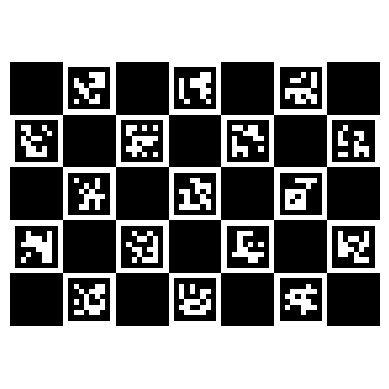

In [7]:

# Load the dictionary of ArUco for 6x6
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)

# Create the board, draw it, and save it in the folder
board = aruco.CharucoBoard((7, 5), 1, 0.8, aruco_dict)
imboard = board.generateImage((2000, 2000))
cv2.imwrite(os.path.join(workdir, "chessboard.tiff"), imboard)

#Create a figure with a subplot and plot it below for an inspection of the ChAruco board (we are using various settings)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()


You need to <font color='red'>print</font> the board.

Stick the board on a rigid surface, e.g. an A4 notepad, and <font color='red'>take photos</font> from multiple angles (>=20) with the camera you want to calibrate.

Save them in the folder workdir/images.

### Use the board to calibrate the camera
The next piece of code will load all the images from the \images folder

In [8]:
datadir = os.path.join(workdir, "images")
images = np.array([
    os.path.join(datadir, f)
    for f in os.listdir(datadir)
    if f.lower().endswith(".jpg")
])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_05_Pro_01.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_11_Pro_02.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_17_Pro_03.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_22_Pro_04.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_30_Pro_05.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_36_Pro_06.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_51_Pro_07.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_47_57_Pro_08.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_48_03_Pro_09.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_48_11_Pro_10.jpg',
       'C:\\python\\IDESA_Ball_Rover\\workdir\\images\\WIN_20260107_12_48_17_Pro_11.jpg',
       'C:

We are going to print the images to see what you have got. Check that all images show the board

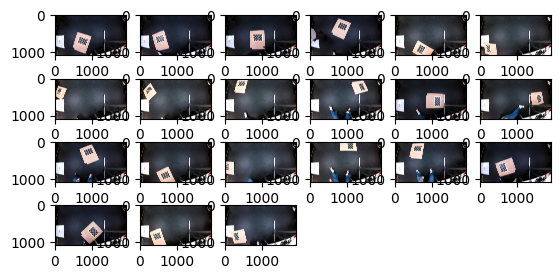

In [9]:
plotsize=round(math.sqrt(len(images)))+1
fig = plt.figure()
t=1
for an_im in images:
    im = PIL.Image.open(an_im)
    ax = fig.add_subplot(plotsize,plotsize,t)
    t+=1
    plt.imshow(im)


Zoom to the first image (index:0)

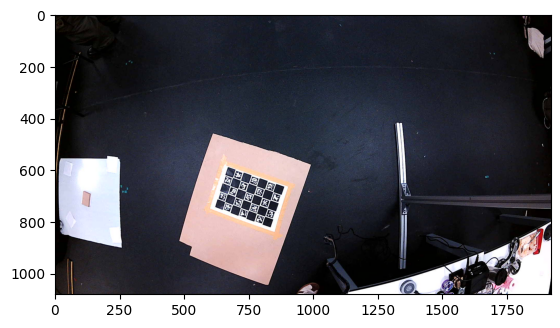

In [10]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first (read_chessboards) will detect markers on all the images and.
* The second (calibrate_camera) will proces the detected markers to estimage the camera calibration data.

The code below is the definition of the function to read the chessboard

In [11]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

The line below calls the above function for all images and saves the results in allCorners, allIds

In [12]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_05_Pro_01.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_11_Pro_02.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_17_Pro_03.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_22_Pro_04.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_30_Pro_05.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_36_Pro_06.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_51_Pro_07.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_47_57_Pro_08.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_48_03_Pro_09.jpg
=> Processing image C:\python\IDESA_Ball_Rover\workdir\images\WIN_20260107_12_48_11_Pro_10.jpg
=> Processing image C:\pyt

And this is the definition of the function that performs the calibration

In [13]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

Now we run the calibration function and get back a number of variables.

ret: is the reprojection error obtained from the calibration (the smaller the better)
CM : is the camera matrix to pass to the pose estimation
dist_coef: is the distrortion coefficient matrix to pass to the pose estimation
rvecs, tvecs: are the rotational and translational matrices of the ArUco markers the function used.

(Note: By executing the function with %time in the begining we are going to get the duration this command will take)

In [14]:
%time ret, CM, dist_coef, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: total: 1.19 s
Wall time: 1.36 s


### Check calibration results

First let's look at the different coeefficients we have obtained and assess the quality of the calibration

In [15]:
print(f"Reprojection error: {ret:.3f} pixels")
# Good calibration: < 0.5 pixels
# Acceptable: 0.5-1.0 pixels  
# Poor: > 1.0 pixels


Reprojection error: 0.967 pixels


In [16]:
print("Distortion coefficients:")
print(f"k1={dist_coef[0][0]:.4f}, k2={dist_coef[1][0]:.4f}, p1={dist_coef[2][0]:.4f}")
print(f"p2={dist_coef[3][0]:.4f}, k3={dist_coef[4][0]:.4f}")
# Large k1, k2 values indicate significant radial distortion

Distortion coefficients:
k1=0.0473, k2=-0.0868, p1=-0.0082
p2=0.0174, k3=0.0377


Finally, let's see two outputs of the calibration and evaluate them visually

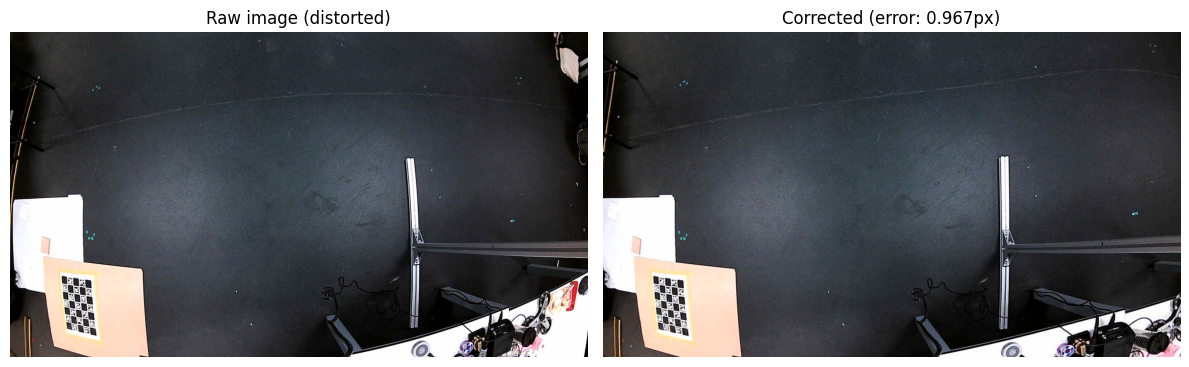

In [17]:
# Add grid overlay to see distortion
i = 5
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame, CM, dist_coef, None)

axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0].set_title("Raw image (distorted)")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Corrected (error: {ret:.3f}px)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Save the Camera Matrix and the distortion Coefficient using numpy

Finally, we save the CM and dist_coef in a npz file for later use. We can change the name to include an indication of the camera this information refers to.

In [18]:
np.savez('Calibration.npz', CM=CM, dist_coef=dist_coef)


Finally, we load the variables from the file and compare them to the ones we calculated earlier to ensure everything is correct.

In [19]:
CM_test, dist_coef_test = np.load('Calibration.npz')['CM'], np.load('Calibration.npz')['dist_coef']

assert np.array_equal(CM, CM_test), "Camera Matrix does not match!"
assert np.array_equal(dist_coef, dist_coef_test), "Distortion Coefficients do not match!"

# If no assertion error is raised, the saved and loaded values match